## About:

Author(s): Leon,

This notebook contains code for getting image filepaths and labels, transforming the images and then saving the transformed images into a new folder.

The steps are as follows:

* Getting the filepaths and image labels for the image datasets: 
1.  cric_cropped 
2.  cric_full
3.  mendeley/hussain
4.  cervix93

* The image labels are then transformed into binary labels. 
* The lists of filepaths and image labels are then joined together.
* The filepaths are then passed into a tensorflow data pipeline which applies a basic image transform (resize to 90x90 and greyscale but this can easily be expanded to something more complex). 
* The modified images are then shuffled, split into train/valid/test splits and then saved into a sub folder matching the image label. 


## To do: 
* Optimise the image saving process to make it more efficient
* Copy notebook and make new functions to accept multi-class labels from the filenames
* Write function to process Cdetector images/labels. 


In [18]:
import os
# !pip install shutil
import shutil
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
#!pip install git+https://github.com/albumentations-team/albumentations
import albumentations as A
# if have trouble installing/importing albumentations package , 
# try updating pip: pip install --upgrade pip
import cv2

In [2]:
#define various file paths
#general file paths
data_folder = os.path.join('..','data')
os.chdir(data_folder)
raw_data_folder = os.path.join(data_folder,'raw')

#cric_cropped dataset:
cric_cropped = os.path.join(data_folder,'raw/Image_datasets/partner_provided_datasets/cric_cropped/Base_balanceada_dividida')
cric_cropped_2_class_dir = os.path.join(cric_cropped,'2_classes')
cric_cropped_train_dir = os.path.join(cric_cropped_2_class_dir,'Treino')
cric_cropped_val_dir = os.path.join(cric_cropped_2_class_dir,'Validacao')
cric_cropped_test_dir = os.path.join(cric_cropped_2_class_dir,'Teste')

#cric full
cric_full = os.path.join(data_folder,'raw/Image_datasets/partner_provided_datasets/CRIC_FullSlide_dataset')

#mendeley hussain
mend_hussain = os.path.join(data_folder,'raw/Image_datasets/partner_provided_datasets/mendeley_hussain_liquid_based_cytology')

#cervix 93
cervix_93 = os.path.join(data_folder,'raw/Image_datasets/partner_provided_datasets/cervix_93/dataset')

#cdetector
cdetector_train = os.path.join(data_folder,'raw/Image_datasets/partner_provided_datasets/Cdetector/train/train')
# cdetector_test = os.path.join(data_folder,'raw/Image_datasets/partner_provided_datasets/Cdetector/train/train')



In [3]:
#rename folders/files in directory to have underscores instead of spaces
# def renam_folders(input_folder):
    # for file in os.listdir(input_folder):
    #     old_name = file
    #     new_name = file.replace(' ','_')
    #     old_path = os.path.join(input_folder,f"{old_name}")
    #     new_path = os.path.join(input_folder,new_name)
    #     os.rename(old_path,new_path)

### Get filepaths and labels for each dataset:

Now for each dataset we get a list of image filepaths and an associated binary label

In [4]:
#get paths and binary labels for cric cropped
def get_bin_filepaths_labels_cric_cropped(cric_cropped_filepath):
    '''
    inputs = cric cropped folder location
    outputs = one array for the image filepaths , one array for the binary labels
    '''
    image_paths = [] #empty list to store filepaths
    labels = [] # empty list to store image labels

    for root, dirnames, filenames in os.walk(cric_cropped_filepath): #look at all folders and subfolders and get the filenames
        for filename in filenames: #loop through filenames
          temp_path = os.path.join(root,filename) # temp filepath
#           print(temp_path)
          image_paths.append(temp_path) # add to image paths list
          temp_label = filename.split('_')[1] #NB this line specific to this dataset
          labels.append(temp_label) # add label to label list

      #convert list into array
    labels_array = np.array(labels)
    labels_array = labels_array.astype(int)
    return image_paths, labels_array

#get all filepaths and labels from tain/valid/split folders
cric_cropped_paths_train , cric_cropped_labels_train = get_bin_filepaths_labels_cric_cropped(cric_cropped_train_dir)
cric_cropped_paths_val , cric_cropped_labels_val = get_bin_filepaths_labels_cric_cropped(cric_cropped_val_dir)
cric_cropped_paths_test , cric_cropped_labels_test = get_bin_filepaths_labels_cric_cropped(cric_cropped_test_dir)

#combine all filepaths and all labels
cric_cropped_bin_paths_all = np.concatenate((cric_cropped_paths_train,
                                         cric_cropped_paths_val,
                                        cric_cropped_paths_test), axis=0)

cric_cropped_bin_labels_all = np.concatenate((cric_cropped_labels_train,
                                         cric_cropped_labels_val,
                                        cric_cropped_labels_test), axis=0)
#error checking
print(np.shape(cric_cropped_labels_train))
print(np.shape(cric_cropped_labels_val))
print(np.shape(cric_cropped_labels_test))

print(np.shape((cric_cropped_bin_labels_all)))

(5514,)
(1381,)
(650,)
(7545,)


In [5]:
#get paths and binary labels for cric full
def get_bin_filepaths_labels_cric_full(cric_full_filepath):
    '''
    inputs = cric full images folder location
    outputs = one array for the image filepaths , one array for the binary labels
    '''
    image_paths = [] #empty list to store filepaths
    labels = [] # empty list to store image labels
    

    for root, dirnames, filenames in os.walk(cric_full_filepath): #look at all folders and subfolders and get the filenames
        for filename in filenames: #loop through filenames
          temp_path = os.path.join(root,filename) # temp filepath
#           print(temp_path)
          image_paths.append(temp_path) # add to image paths list
          temp_label = filename.split('_')[-2] #NB this line specific to this dataset
          labels.append(temp_label) # add label to label list

      #convert list into array
    labels_array = np.array(labels)
#     labels_array = labels_array.astype(int)
    return image_paths, labels_array

cric_full_paths , cric_full_labels = get_bin_filepaths_labels_cric_full(cric_full)

def label_mapping_bin_cric_full(x):
  if x == 'NILM':
    return 0
  else:
    return 1

#convert labels into 0s and 1s
vf = np.vectorize(label_mapping_bin_cric_full)
cric_full_labels_new_bin = vf(cric_full_labels).astype(int)

In [6]:
#get paths and binary labels for mendeley hussain
def get_bin_filepaths_labels_mend(mend_dir):
    '''
    inputs = mendeley images folder location
    outputs = one array for the image filepaths , one array for the binary labels
    '''
    image_paths = [] #empty list to store filepaths
    labels = [] # empty list to store image labels
    
    for root, dirnames, filenames in os.walk(mend_dir,topdown=True): #look at all folders and subfolders and get the filenames
      for dir in dirnames:
        temp_dir_path = os.path.join(root,dir)
        print('Looking at :',dir)
        files_in_dir = os.listdir(temp_dir_path)
        for filename in files_in_dir: #loop through filenames
          if filename == 'Results.csv':
            pass
          else:
            temp_path = os.path.join(root,dir,filename) # temp filepath
            #print(temp_path)
            image_paths.append(temp_path) # add to image paths list
            # if looking at other datasets, below line needs to be modified to get image label from filepath
            temp_label = filename.split('_')[0]
            labels.append(temp_label) # add label to label list

      #convert list into array
    image_paths_array = np.array(image_paths)
    labels_array = np.array(labels)
    # labels_array = labels_array.astype(int)
    return image_paths_array, labels_array


mend_all_paths , mend_all_labels = get_bin_filepaths_labels_mend(mend_hussain)

#convert labels into 0s and 1s
def label_mapping_mend(x):
  if x == 'NL':
    return 0
  else:
    return 1

vf = np.vectorize(label_mapping_mend)
mend_labels_new_bin = vf(mend_all_labels).astype(int)

Looking at : High_squamous_intra-epithelial_lesion
Looking at : Negative_for_Intraepithelial_malignancy
Looking at : Low_squamous_intra-epithelial_lesion
Looking at : Squamous_cell_carcinoma


In [7]:
#get binary labels and filepaths for cervix 93
def get_bin_filepaths_labels_cerv93(cervix93_dir):
     '''
    inputs = cervix93 images folder location
    outputs = one array for the image filepaths , one array for the binary labels
    '''
    image_paths = [] #empty list to store filepaths
    labels = [] # empty list to store image labels
    
    #read csv file with labels
    cervix_93_labels = pd.read_csv(os.path.join(data_folder,'raw/Image_datasets/partner_provided_datasets/cervix_93/dataset/labels.csv'))
    
    #init empty lists
    image_paths = [] #empty list to store filepaths
    labels = [] # empty list to store image labels
    
    for root, dirnames, filenames in os.walk(cervix93_dir,topdown=True): #look at all folders and subfolders and get the filenames
      for dir in dirnames:
        if dir.split('_')[-1] == 'stack':
          dir_path = os.path.join(root,dir)
#           print('Looking at :',dir)
          files_in_dir = os.listdir(dir_path)
          temp_frame = dir_path.split('/')[-1].split('_')[-2]
#           print(temp_frame)
          temp_label = cervix_93_labels.loc[cervix_93_labels['frame'] == temp_frame].label.values[0] #get label string from pandas df
          for filename in files_in_dir: #loop through filenames
            if filename != 'labels.csv':
              temp_path = os.path.join(root,dir,filename) # temp filepath
              # print(temp_path)
              image_paths.append(temp_path) # add to image paths list
              # if looking at other datasets, below line needs to be modified to get image label from filepath
              labels.append(temp_label) # add label to label list

      #convert list into array
    image_paths_array = np.array(image_paths)
#     labels_array = np.array(labels)
    # labels_array = labels_array.astype(int)
    return image_paths_array, labels


cervix93_all_paths , cervix93_all_labels = get_bin_filepaths_labels_cerv93(cervix_93)

#convert labels to 0s and 1s
def label_mapping_cervix(x):
  if x == 'N':
    return 0
  else:
    return 1

vf = np.vectorize(label_mapping_cervix)
cervix93_labels_new_bin = vf(cervix93_all_labels).astype(int)
# cervix93_labels_new_bin = cervix93_labels_new_bin.reshape(-1)

## Combine filepath lists and label lists

In [8]:
filepath_list = [cric_cropped_bin_paths_all, 
                  cric_full_paths, 
                  mend_all_paths, 
                  cervix93_all_paths]

labels_list = [cric_cropped_bin_labels_all, 
                cric_full_labels_new_bin, 
                mend_labels_new_bin, 
                cervix93_labels_new_bin]

def combine_filepath_lists_label_lists(filepath_list,labels_list):
    '''
    inputs: 
    list containing x number of filepath arrays (1 per dataset)
    list containing x number of label arrays (1 per dataset)
    outputs:
    one array for all the filepaths
    one array for all the labels
    '''
    #error checking:
    if len(filepath_list) != len(labels_list):
        raise ValueError('different lengths of filepath and label lists')
    for x in range(len(filepath_list)):
        if len(filepath_list[x]) != len(labels_list[x]):
            raise ValueError(f'paths or labels at position {x} are different lengths')
    
    #combine filepaths/labels
    for x in range(0,len(filepath_list)):
        print(f'item {0} with length {len(filepath_list[x])}')
        
        if x == 0: # if x = 0 do nothing as we need two items to concat
            continue
        if x == 1: #if x = 1, create temp array with concat items 0 and 1
            temp_filepath_array = np.concatenate((filepath_list[0],filepath_list[1]),axis=0)
            temp_labels_array = np.concatenate((labels_list[0],labels_list[1]),axis=0)
        else: # add/concat the next item to the temp array
            temp_filepath_array = np.concatenate((temp_filepath_array,filepath_list[x]))
            temp_labels_array = np.concatenate((temp_labels_array,labels_list[x]))
     
    print(f'final array lengths: {len(temp_filepath_array)}')
    return temp_filepath_array, temp_labels_array
    
all_bin_filepaths , all_bin_labels = combine_filepath_lists_label_lists(filepath_list,labels_list)

item 0 with length 7545
item 0 with length 400
item 0 with length 962
item 0 with length 1602
final array lengths: 10509


## Vectorize image processing

In [9]:
#
def shuffle_paths_labels(filepaths, labels):
    shuff_filepaths , shuff_labels = shuffle(filepaths, labels, random_state=42)
    return shuff_filepaths, shuff_labels

all_bin_filepaths_shuff , all_bin_labels_shuff = shuffle_paths_labels(all_bin_filepaths ,all_bin_labels)

In [23]:
from collections import Counter
#check the types of images we have
image_types = []
for path in all_bin_filepaths_shuff:
    image_type = path.split('.')[-1]
    image_types.append(image_type)
    
Counter(image_types)


Counter({'png': 9547, 'jpg': 962})

In [11]:
#error checking
for x in range(10):
    print(f'{all_bin_filepaths_shuff[x]}    {all_bin_labels_shuff[x]}')

../data/raw/Image_datasets/partner_provided_datasets/cervix_93/dataset/frame050_stack/fov010.png    1
../data/raw/Image_datasets/partner_provided_datasets/cric_cropped/Base_balanceada_dividida/2_classes/Treino/3609_1_.png    1
../data/raw/Image_datasets/partner_provided_datasets/cric_cropped/Base_balanceada_dividida/2_classes/Treino/3406_1_.png    1
../data/raw/Image_datasets/partner_provided_datasets/cric_cropped/Base_balanceada_dividida/2_classes/Treino/627_0_.png    0
../data/raw/Image_datasets/partner_provided_datasets/cervix_93/dataset/frame046_stack/fov012.png    1
../data/raw/Image_datasets/partner_provided_datasets/cric_cropped/Base_balanceada_dividida/2_classes/Treino/3165_1_.png    1
../data/raw/Image_datasets/partner_provided_datasets/CRIC_FullSlide_dataset/LSIL_184.png    1
../data/raw/Image_datasets/partner_provided_datasets/cric_cropped/Base_balanceada_dividida/2_classes/Treino/1118_0_.png    0
../data/raw/Image_datasets/partner_provided_datasets/CRIC_FullSlide_dataset/NI

The below function is a vectorised image loading function. It will take in a list of filepaths and instead of loading them one at a time into the tensorflow pipeline, it will process a number of images in parallel, greatly speeding up image loading and modification. 

In [24]:
def make_processed_tf_dataset(filepaths,labels,transforms):
    '''
    inputs: filepath array, label array, and an Albumentations transformation pipeline (https://albumentations.ai/docs/api_reference/full_reference)
    outputs: a tensorflow dataset containing both transformed images and binary labels
    '''

    def parse_image(filename):
        '''
        input: path to image
        output: transformed/resized numpy array
        '''
        tf_filename = tf.io.read_file(filename) #read filename
        image_type = tf.strings.split(filename,'.')[-1] #check image type
        #decode image to grayscale tensor depending on imagetype 
        if image_type == "png":
            image = tf.io.decode_png(tf_filename, channels=1)
        elif image_type == "jpg":
            image = tf.io.decode_jpeg(tf_filename, channels=1)
        else:
            print(f'unexpected image type {filename}')
            
        np_image = image.numpy()[:,:,0]  #convert to np array , drop channel dim as color dim not needed

        if transforms == None: # if no transform is given, no image transforation is needed
          aug_image = np_image
        else:
          aug_image = transforms(image=np_image)["image"] #apply transforms on image

        aug_image = tf.cast(aug_image, tf.float32) #convert type to match with wrapper function
        return aug_image



    #wrap parse image function as tensorflow function
    def tf_parse_image(input):
        y = tf.numpy_function(parse_image, [input],tf.float32) 
        return y 
    
    #currently not batching images to be passed into model so not needed
#   def configure_for_performance(ds): #takes tensor dataset as input and optimises for repeated calls 
#     ds = ds.shuffle(buffer_size=10000)
#     ds = ds.batch(batch_size)
#     ds = ds.repeat()
#     ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
#     return ds

  
    filenames_ds = tf.data.Dataset.from_tensor_slices(filepaths) #make dataset of filenames
    print('file names parsed')
    images_ds = filenames_ds.map(lambda x: tf_parse_image(x), num_parallel_calls=tf.data.experimental.AUTOTUNE) #maps parse image function to filenames dataset to create images
    print('images ds created')
    labels_ds = tf.data.Dataset.from_tensor_slices(labels.astype(int)) #make ds of labels
    print('label ds created')
    ds_out = tf.data.Dataset.zip((images_ds, labels_ds))
    print('ds out created')
    return ds_out

#we define basic albumentations image transform to make sure it is working correctly
test_transform = A.Compose([
    A.Resize(90,90)
])
    
transformed_ds = make_processed_tf_dataset(all_bin_filepaths_shuff, all_bin_labels_shuff,test_transform) 



file names parsed
images ds created
label ds created
ds out created


## Error checking

filepath from array:  ../data/raw/Image_datasets/partner_provided_datasets/cervix_93/dataset/frame050_stack/fov010.png
label from array:  1
label from tf  tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor([90 90], shape=(2,), dtype=int32)


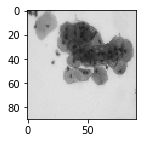

filepath from array:  ../data/raw/Image_datasets/partner_provided_datasets/cric_cropped/Base_balanceada_dividida/2_classes/Treino/3609_1_.png
label from array:  1
label from tf  tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor([90 90], shape=(2,), dtype=int32)


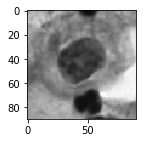

filepath from array:  ../data/raw/Image_datasets/partner_provided_datasets/cric_cropped/Base_balanceada_dividida/2_classes/Treino/3406_1_.png
label from array:  1
label from tf  tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor([90 90], shape=(2,), dtype=int32)


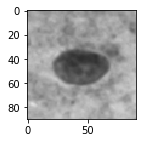

filepath from array:  ../data/raw/Image_datasets/partner_provided_datasets/cric_cropped/Base_balanceada_dividida/2_classes/Treino/627_0_.png
label from array:  0
label from tf  tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor([90 90], shape=(2,), dtype=int32)


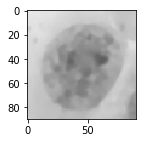

filepath from array:  ../data/raw/Image_datasets/partner_provided_datasets/cervix_93/dataset/frame046_stack/fov012.png
label from array:  1
label from tf  tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor([90 90], shape=(2,), dtype=int32)


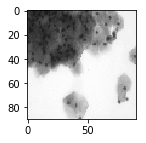

filepath from array:  ../data/raw/Image_datasets/partner_provided_datasets/cric_cropped/Base_balanceada_dividida/2_classes/Treino/3165_1_.png
label from array:  1
label from tf  tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor([90 90], shape=(2,), dtype=int32)


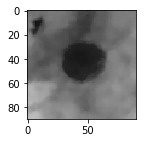

filepath from array:  ../data/raw/Image_datasets/partner_provided_datasets/CRIC_FullSlide_dataset/LSIL_184.png
label from array:  1
label from tf  tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor([90 90], shape=(2,), dtype=int32)


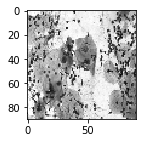

filepath from array:  ../data/raw/Image_datasets/partner_provided_datasets/cric_cropped/Base_balanceada_dividida/2_classes/Treino/1118_0_.png
label from array:  0
label from tf  tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor([90 90], shape=(2,), dtype=int32)


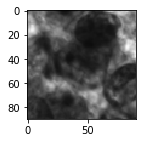

filepath from array:  ../data/raw/Image_datasets/partner_provided_datasets/CRIC_FullSlide_dataset/NILM_152.png
label from array:  0
label from tf  tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor([90 90], shape=(2,), dtype=int32)


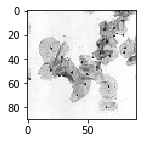

filepath from array:  ../data/raw/Image_datasets/partner_provided_datasets/cervix_93/dataset/frame072_stack/fov008.png
label from array:  1
label from tf  tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor([90 90], shape=(2,), dtype=int32)


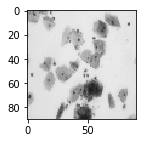

In [25]:
x = 0
for images,labels in transformed_ds.take(10):
  print('filepath from array: ',all_bin_filepaths_shuff[x]) 
  print('label from array: ',all_bin_labels_shuff[x])
  print('label from tf ',labels)
  print(tf.shape(images))
  # print(images)
  # img = mpimg.imread(images)
  #new_image = images[:,:].map(contrast)
  plt.rcParams["figure.figsize"] = (2,2)
  plt.imshow(images[:,:],cmap='gray', vmin=0, vmax=255)
  plt.show()
  x +=1

## Save modified images

In [15]:

to_save_dir = os.path.join(os.getcwd(),'processed/testing') #create new folder
train_split_folders = ['train','valid','test']

#create train/valid/test split folders along with label sub folder

#create folders if needed
for folder in train_split_folders:
    for label in np.unique(all_bin_labels_shuff):
        os.makedirs(os.path.join(to_save_dir,folder,str(label)))
    



FileExistsError: [Errno 17] File exists: '/home/leon/Documents/github/cerv_ai/data/processed/testing/train/0'

In [26]:
#it seems likely that there is a bottle neck in the image saving process in this cell
#possbily this can be parallelised somehow or made more efficient

x = 0
for images,labels in transformed_ds.take(-1): #get all images
    #choose which train/valid/test folder to place image in:
    folder = np.random.choice(train_split_folders,p=[0.8,0.1,0.1])
    
    #get image label/class
    np_label = labels.numpy()

    #convert image to array
    temp_image = images.numpy()

    #keep original filename
    file_path = all_bin_filepaths_shuff[x]
    filename = file_path.split('/')[-1] #get last section of filepath which is filename
    filename = filename.split('.')[-2] #drop .jpeg or .png

    #save image based on train/valid/test and 0 or 1 label
    if np_label == 1:
        path_to_save = os.path.join(to_save_dir,folder,'1',filename)+'.png' #create path and filename
    elif np_label == 0:
        path_to_save = os.path.join(to_save_dir,folder,'0',filename)+'.png'
    
    #save the image to the relevant folder (possible TODO , can be optimised)
    cv2.imwrite(path_to_save,temp_image) 

    if x % 100 == 1: #progress bar
        print(x,' images saved')
    else:
        pass

    x+=1 

print('all images saved')

1  images saved
101  images saved
201  images saved
301  images saved
401  images saved
501  images saved
601  images saved
701  images saved
801  images saved
901  images saved
1001  images saved
1101  images saved
1201  images saved
1301  images saved
1401  images saved
1501  images saved
1601  images saved
1701  images saved
1801  images saved
1901  images saved
2001  images saved
2101  images saved
2201  images saved
2301  images saved
2401  images saved
2501  images saved
2601  images saved
2701  images saved
2801  images saved
2901  images saved
3001  images saved
3101  images saved
3201  images saved
3301  images saved
3401  images saved
3501  images saved
3601  images saved
3701  images saved
3801  images saved
3901  images saved
4001  images saved
4101  images saved
4201  images saved
4301  images saved
4401  images saved
4501  images saved
4601  images saved
4701  images saved
4801  images saved
4901  images saved
5001  images saved
5101  images saved
5201  images saved
5301 

In [ ]:
to_save_dir